# Demo 2: diffraction pattern from uniform disk

In this demo, we simulate the radiation pattern coming from a uniform current distribution on a disk onto a detector plane, multiple Fraunhofer distances above it. We then compare the cross-sections of the propagated field distribution along the x and y axes to the theoretical Airy disk emanating from the uniform disk.

The Airy disk has the following mathematical representation:
$$
I_\mathrm{Airy} = I_0 \left( \frac{2 J_1(x)}{x} \right)^2,
$$

with $I_0$ the initial intensity, $x=\frac{2 \pi r \rho}{\lambda D}$, where $r$ is the radius of the disk, $\rho$ the radial distance of a point on the detector w.r.t. detector center and $D$ the distance between disk and detector. $J_1(x)$ represents the Bessel function of the first kind of order one.

2026-02-22 17:48:09 - WARNING - System override set to True. 
2026-02-22 17:48:09 - INFO - Added plane disk to system. 
2026-02-22 17:48:09 - INFO - Added plane detector to system. 
2026-02-22 17:48:09 - INFO - Translated element detector by ('0.000e+00', '0.000e+00', '1.000e+03') millimeters. 
2026-02-22 17:48:09 - WORK - *** Starting PO propagation *** 
2026-02-22 17:48:09 - WORK - Propagating source on disk to detector, propagation mode: EH. 
2026-02-22 17:48:09 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-22 17:48:09 - WORK - ... Calculating ... 
2026-02-22 17:48:11 - WORK - *** Finished: 1.783 seconds *** 


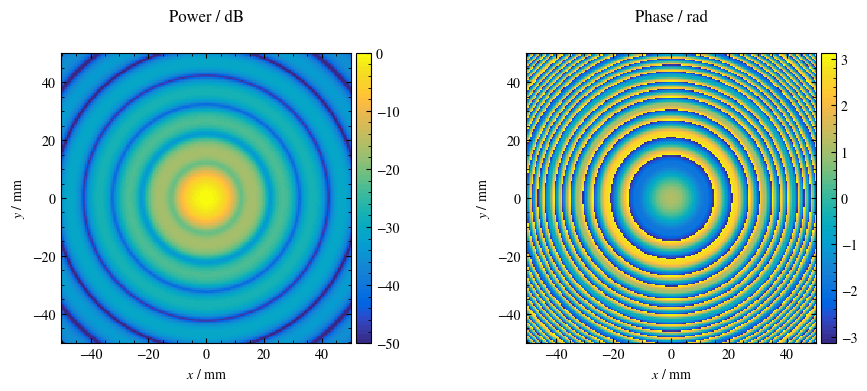

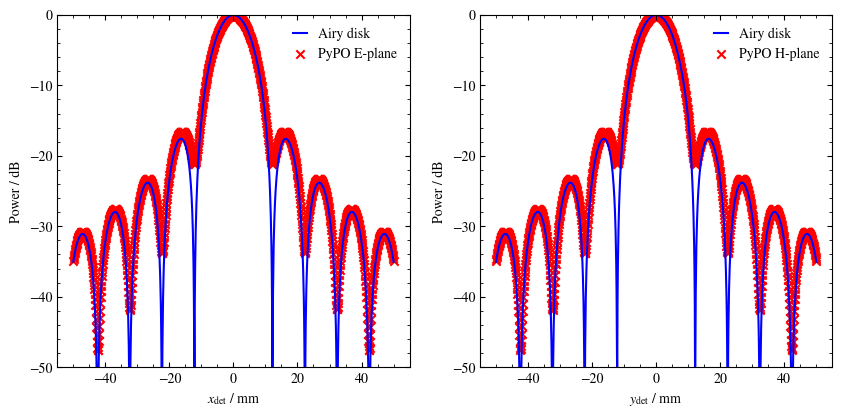

In [1]:
#%matplotlib widget 
# Uncomment for interactive plots when running the notebook!
# Requires installation of the ipympl package

import numpy as np

from scipy.special import j1
from PyPO.System import System
from PyPO.Enums import FieldComponents, Modes, Scales, Units

import matplotlib.pyplot as pt

s = System()
    
# Setting up parameters for defining simulation.
# Source parameters and distances
lam = 0.1*Units.MM                # Wavelength of light in mm
r_disk = 5*Units.MM               # Radius of disk in mm
D = 4 * r_disk**2 / lam  # Distance between disk and screen. 
                         # We choose Fraunhofer distance times four for this simulation.

# Target parameters
lims = 50                # Limits in x and y, in mm

# Setting up surface dictionaries and source current distributions.
disk = {
        "name"      : "disk",
        "gmode"     : "uv",
        "lims_u"    : np.array([0, r_disk])*Units.MM,
        "lims_v"    : np.array([0, 360]),
        "gridsize"  : np.array([201, 200])
        }

detector = {
        "name"      : "detector",
        "gmode"     : "xy",
        "lims_x"   : np.array([-lims, lims])*Units.MM,
        "lims_y"   : np.array([-lims, lims])*Units.MM,
        "gridsize"  : np.array([201, 201])
        }

UDict = {
        "name"      : "source",
        "lam"       : lam
        }

# Add all stuff and translate detector plane to a distance D above the disk.
s.addPlane(disk)
s.addPlane(detector)
s.translateGrids("detector", np.array([0, 0, D])*Units.MM)

s.createUniformSource(UDict, "disk")

# Setting up physical optics propagation
source_to_detector = {
        "s_current"    : "source",
        "t_name"        : "detector",
        "name_EH"       : "EH_detector",
        "mode"          : "EH"
        }

s.runPO(source_to_detector)

s.plotBeam2D("EH_detector", FieldComponents.Ex, vmin=-50)

# Extract field cuts and corresponding x and y ranges. Note we want cross-sections in decibels.
E, H, x, y = s.calcBeamCuts("EH_detector", FieldComponents.Ex, center=False, align=False, scale=Scales.dB)

# Make finer x and y arrays for generating Airy disk.
x_fine = np.linspace(x[0], x[-1], 1000)
y_fine = np.linspace(y[0], y[-1], 1000)

x_bessel = 2 * np.pi * r_disk * np.absolute(x_fine) / lam / D
y_bessel = 2 * np.pi * r_disk * np.absolute(y_fine) / lam / D

# Note that we convert the Airy disk pattern to decibels. This is good for seeing differences on small power scales.
j1_x_dB = 20 * np.log10(np.absolute(2 * j1(x_bessel) / x_bessel))
j1_y_dB = 20 * np.log10(np.absolute(2 * j1(y_bessel) / y_bessel))

# Plot all the stuff
fig, ax = pt.subplots(1,2, figsize=(10,5))
ax[0].plot(x_fine, j1_x_dB, color="blue", label="Airy disk")
ax[0].scatter(x, E, marker="x", color="red", label="PyPO E-plane")
ax[0].set_ylim(-50, 0)
ax[0].legend(frameon=False, prop={'size': 10},handlelength=1)
ax[0].set_box_aspect(1)
ax[0].set_xlabel(r"$x_\mathrm{det}$ / mm")
ax[0].set_ylabel("Power / dB")

ax[1].plot(y_fine, j1_y_dB, color="blue", label="Airy disk")
ax[1].scatter(y, H, marker="x", color="red", label="PyPO H-plane")
ax[1].set_ylim(-50, 0)
ax[1].legend(frameon=False, prop={'size': 10},handlelength=1)
ax[1].set_xlabel(r"$y_\mathrm{det}$ / mm")
ax[1].set_ylabel("Power / dB")
ax[1].set_box_aspect(1)

pt.show()

As expected, the beam pattern on the detector screen resembles the rings that are a characteristic of Airy patterns.

To investigate a bit further, we look at the cross-sections.
We select the cross-sections of the diffraction pattern along the x and y-axes. We use the generated x and y co-ordinates to generate the Airy patterns along the same axes and plot these together with the simulated diffraction pattern. It can be seen that `PyPO` and the Airy disk are generally similar.